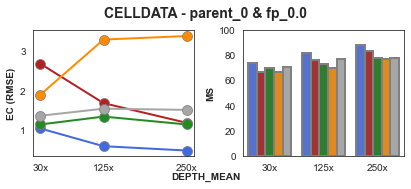

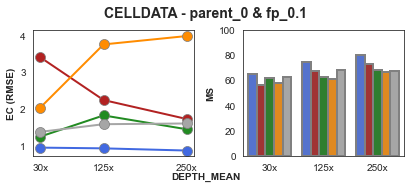

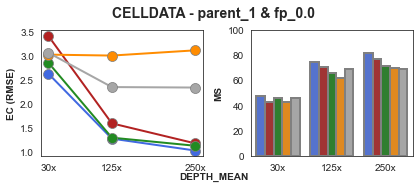

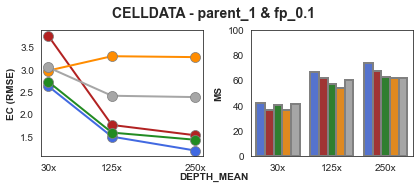

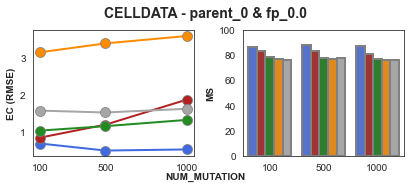

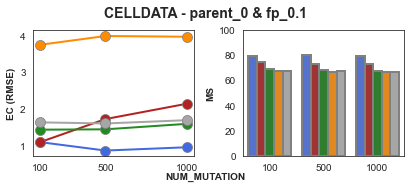

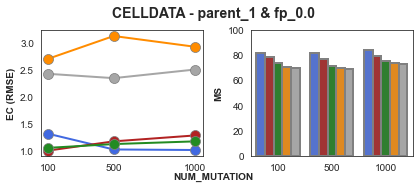

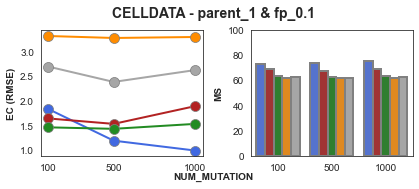

In [8]:
import numpy as np 
import pandas as pd
import os, glob

def drawfigure (long_df, x, title, saveloc ):
    import matplotlib 
    matplotlib.rcParams["font.family"] = 'arial'
    import palettable
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import ttest_ind

    tabl = palettable.tableau.Tableau_20.mpl_colors
    safe7 = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    Gr_10 = palettable.scientific.sequential.GrayC_20.mpl_colors

    #colorlist = [i for i in safe7]
    colorlist = ["royalblue", "firebrick", "forestgreen", "darkorange", Gr_10[6], Gr_10[5], Gr_10[4]]
    sns.set_style("white")
    #sns.set_palette("tab10")
    sns.set_palette(sns.color_palette(colorlist))


    # Create a grouped bar graph
    fig, ax = plt.subplots( nrows = 1, ncols = 2, figsize = (6, 2.5))
    fig.subplots_adjust ( wspace = 0.3, bottom = 0.15, top = 0.85, left = 0.1, right = 0.96)
    

    sns.lineplot(data = long_df, x = x, y = 'EC', hue = 'tool', 
                    linewidth = 2, marker = 'o',  markersize = 10, markeredgecolor = "gray", 
                    err_style = "band", errorbar=('ci', 95), ax = ax[0])
    ax[0].set_xlabel( None )
    ax[0].set_ylabel( "EC (RMSE)", fontsize = 10, fontweight = "semibold" )
    ax[0].set_xticks ( sorted(list ( set(long_df[x])) ) ) 
    if x == "DEPTH_MEAN":
        ax[0].set_xticklabels ( [ str(i) + str ("x") for i in sorted( list ( set(long_df[x]) ) ) ] ) 
    ax[0].legend_.remove()
    #ax[0].legend ( title = None, labels = ["CLEMENT", "pyclone", "sciclone", "qc"] )


    sns.barplot(data = long_df, x = x, y = 'MS', hue = 'tool', 
                    linewidth = 2, edgecolor='gray', 
                    dodge = True,
                    ax = ax[1])
    ax[1].set_xlabel( None )
    ax[1].set_ylabel( "MS", fontsize = 10, fontweight = "semibold" )
    ax[1].set_ylim( [0, 100.1] )
    ax[1].set_yticks ( np.linspace (0, 100.1, 6) ) 
    if x == "DEPTH_MEAN":
        ax[1].set_xticklabels ( [ str(i) + str ("x") for i in sorted( list ( set(long_df[x]) ) ) ] ) 
    legend_s = ax[1].legend(  loc = "lower center", ncol=5, frameon=False ) # bbox_to_anchor=(0.1, 0.8
    ax[1].legend_.remove()
    #ax[1].legend ( title = None, labels = ["CLEMENT", "pyclone", "sciclone", "qc"] )

    plt.suptitle( title , fontsize = 14, y = 0.98, fontweight = "semibold" )
    fig.text (x = 0.5, y = 0.02, ha = "center", s = "{}".format( x ), fontsize = 10, fontweight = "semibold")

    plt.savefig ( saveloc, dpi = 300 )
    plt.show()

    
    # # Create Figure 2 for the legend
    # fig_legend, ax_legend = plt.subplots( nrows = 1, ncols = 1, figsize = (12, 1) )

    # # Extract the legend from Figure 1 and add it to Figure 2
    # ax_legend.add_artist( legend_s )
    # sns.despine(ax=ax_legend, left=True, right=True, top=True, bottom=True)
    # ax_legend.set_xticks([])
    # ax_legend.set_yticks([])
    # ax_legend.set_xlabel( None )
    # ax_legend.set_ylabel( None )

    # # Show or save Figure 2
    # plt.show()



def bm_by_depth ( NUM_BLOCK_LIST, NUM_MUTATION_LIST, DEPTH_MEAN_LIST, NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST):
    #toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone"]

    for NUM_PARENT in NUM_PARENT_LIST:        
        for FP_RATIO in FP_RATIO_LIST:
            for AXIS_RATIO in AXIS_RATIO_LIST:        
                long_df = pd.DataFrame ( columns = ["DEPTH_MEAN", "NUM_BLOCK", "NUM_MUTATION", "NUM_PARENT", "FP_RATIO", "AXIS_RATIO", "tool", "MS", "EC"] )
            
                for DEPTH_MEAN in DEPTH_MEAN_LIST:
                    for NUM_BLOCK in NUM_BLOCK_LIST:
                        for NUM_MUTATION in NUM_MUTATION_LIST:
                            INPUT_DIR_LIST = sorted ( glob.glob ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/2.CellData/CellData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN) + "x/parent_" + str (NUM_PARENT) + "/fp_" + str(FP_RATIO) + "/axis_" + str(AXIS_RATIO) + "/BM_FINAL.tsv") )

                            for INPUT_DIR in INPUT_DIR_LIST:
                                if not os.path.exists ( INPUT_DIR ):
                                    print (INPUT_DIR + "없음")
                                    continue

                                df = pd.read_csv (INPUT_DIR , sep = "\t", header = None, index_col = 0)
                                for tool in toollist:
                                    long_df.loc[len(long_df.index)] = [ DEPTH_MEAN, NUM_BLOCK, NUM_MUTATION, NUM_PARENT, FP_RATIO, AXIS_RATIO, tool, df.loc [tool][1], df.loc [tool][3] ]   # 맨 끝에 하나씩 추가

                long_df["MS"] = long_df["MS"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 normalize    
                drawfigure (long_df, 'DEPTH_MEAN', "CELLDATA - parent_{} & fp_{}".format (NUM_PARENT, FP_RATIO, AXIS_RATIO), "/data/project/Alzheimer/YSscript/cle/Revision/by_depth/2.CellData-bydepth_{}_{}_{}.jpg".format (NUM_PARENT, FP_RATIO, AXIS_RATIO))

                # tsv로 정리해서 저장하기
                tt = pd.concat ( [  round (long_df.groupby (["DEPTH_MEAN", "tool"])["EC"].mean() , 2), round (long_df.groupby (["DEPTH_MEAN", "tool"])["MS"].mean() , 2)] , axis = 1)
                tt.columns = ["RMSE_mean", "MS_mean"]
                tt = tt.astype ( {"RMSE_mean" : "str", "MS_mean" : "str"})
                k = 0
                while k < tt.shape[0]:
                    MS_ratio =  [ float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+1]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+2]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+3]["MS_mean"]) ]
                    tt.iloc[k, 1] = tt.iloc[k]["MS_mean"] + " ({}-{}% ↑)".format ( round ( min (MS_ratio) * 100, 1), round ( max (MS_ratio) * 100, 1) )
                    k += len(toollist)
                tt.to_csv ( "/data/project/Alzheimer/YSscript/cle/Revision/by_depth/2.CellData-bydepth_{}_{}.tsv".format (NUM_PARENT, FP_RATIO),  sep = "\t", index = True)



def bm_by_nummutation ( NUM_BLOCK_LIST, NUM_MUTATION_LIST, DEPTH_MEAN_LIST, NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST):
    #toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone"]

    for NUM_PARENT in NUM_PARENT_LIST:        
        for FP_RATIO in FP_RATIO_LIST:
            for AXIS_RATIO in AXIS_RATIO_LIST:        
                long_df = pd.DataFrame ( columns = ["DEPTH_MEAN", "NUM_BLOCK", "NUM_MUTATION", "NUM_PARENT", "FP_RATIO", "AXIS_RATIO", "tool", "MS", "EC"] )
            
                for DEPTH_MEAN in DEPTH_MEAN_LIST:
                    for NUM_BLOCK in NUM_BLOCK_LIST:
                        for NUM_MUTATION in NUM_MUTATION_LIST:
                            INPUT_DIR_LIST = sorted ( glob.glob ("/data/project/Alzheimer/CLEMENT/03.combinedoutput/2.CellData/CellData_" + str(NUM_BLOCK) + "D/n" + str(NUM_MUTATION) + "_" + str(DEPTH_MEAN) + "x/parent_" + str (NUM_PARENT) + "/fp_" + str(FP_RATIO) + "/axis_" + str(AXIS_RATIO) + "/BM_FINAL.tsv") )

                            for INPUT_DIR in INPUT_DIR_LIST:
                                if not os.path.exists ( INPUT_DIR ):
                                    print (INPUT_DIR + "없음")
                                    continue

                                df = pd.read_csv (INPUT_DIR , sep = "\t", header = None, index_col = 0)
                                for tool in toollist:
                                    long_df.loc[len(long_df.index)] = [ DEPTH_MEAN, NUM_BLOCK, NUM_MUTATION, NUM_PARENT, FP_RATIO, AXIS_RATIO, tool, df.loc [tool][1], df.loc [tool][3] ]   # 맨 끝에 하나씩 추가
                    
                long_df["MS"] = long_df["MS"] * (100 / long_df["NUM_MUTATION"])     # 100점 만점으로 normalize
                drawfigure (long_df, 'NUM_MUTATION', "CELLDATA - parent_{} & fp_{}".format (NUM_PARENT, FP_RATIO), "/data/project/Alzheimer/YSscript/cle/Revision/by_nummutation/2.CellData-bynummutation_{}_{}_{}.jpg".format (NUM_PARENT, FP_RATIO, AXIS_RATIO))

                # tsv로 정리해서 저장하기
                tt = pd.concat ( [  round (long_df.groupby (["NUM_MUTATION", "tool"])["EC"].mean() , 2), round (long_df.groupby (["NUM_MUTATION", "tool"])["MS"].mean() , 2)] , axis = 1)
                tt.columns = ["RMSE_mean", "MS_mean"]
                tt = tt.astype ( {"RMSE_mean" : "str", "MS_mean" : "str"})
                k = 0
                while k < tt.shape[0]:
                    MS_ratio =  [ float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+1]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+2]["MS_mean"]), float(tt.iloc[k]["MS_mean"]) / float(tt.iloc[k+3]["MS_mean"]) ]
                    tt.iloc[k, 1] = tt.iloc[k]["MS_mean"] + " ({}-{}% ↑)".format ( round ( min (MS_ratio) * 100, 1), round ( max (MS_ratio) * 100, 1) )
                    k += len(toollist)
                tt.to_csv ( "/data/project/Alzheimer/YSscript/cle/Revision/by_depth/2.CellData-bydepth_{}_{}.tsv".format (NUM_PARENT, FP_RATIO),  sep = "\t", index = True)


if __name__ == "__main__":
    kwargs = {}

    NUM_BLOCK_LIST = [  3  ]             # 1, 2, 3
    NUM_MUTATION_LIST = [1000, 500, 100]    # 1000, 500, 100
    DEPTH_MEAN_LIST = [250, 125, 30]       # 250, 125, 30
    NUM_PARENT_LIST = [ 0, 1 ]       # 0 , 1
    FP_RATIO_LIST = [ 0.0, 0.1  ]        # 0.0, 0.1
    AXIS_RATIO_LIST = [ -1 ]        # -1, 0.0, 0.2

    global toollist
    #toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone"]
    toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone", "simpleK_elbow"]
    #toollist = ["CLEMENT_decision", "pyclonevi", "sciclone", "quantumclone", "simpleK_elbow", "simpleK_silhouette", "simpleK_gap"]
                           

    # Depth에 따른 benchmark
    bm_by_depth ( NUM_BLOCK_LIST, [500], DEPTH_MEAN_LIST, NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST )
    
    #  NUM_MUTATION에 따른 benchmark
    bm_by_nummutation ( NUM_BLOCK_LIST, NUM_MUTATION_LIST, [250], NUM_PARENT_LIST, FP_RATIO_LIST, AXIS_RATIO_LIST )


        